### Importing Necessary Libraries

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
#!pip install pytorch-tabnet
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# # Assuming your dataset is a CSV file named 'my_dataset.csv' in your 'My Drive/Colab Notebooks' folder
# df = pd.read_csv('//content/drive/MyDrive/Colab Notebooks/merged_v2.csv')

In [ ]:
# # Install gdown if not already installed
# !pip install gdown

import gdown

# Google Drive file ID
file_id = "1hV5zbPSeM4IUtzQU9Bf7V7mB9176EGCi"

# Construct the download URL
download_url = f"https://drive.google.com/uc?id={file_id}"

# Download the file and save it locally
output_file = "data.csv"
gdown.download(download_url, output_file, quiet=False)

# Load the CSV file into a DataFrame
import pandas as pd
df1 = pd.read_csv(output_file)

# Display the first few rows
df1.head()


Downloading...
From: https://drive.google.com/uc?id=1hV5zbPSeM4IUtzQU9Bf7V7mB9176EGCi
To: /content/data.csv
100%|██████████| 333k/333k [00:00<00:00, 65.0MB/s]


,longitude,latitude,Area,Soil group,Land class,Soil type,pH,SOC,Nitrogen,Potassium,Phosphorus,Sulfur,Boron,Zinc,Sand,Silt,Clay
0,89.2767,25.5678,Mithpukur,belab,high ground,Clay loam,5.0,1.27,0.08,0.15,19.6,37.7,0.26,0.86,33.0,33.0,33.0
1,89.2767,25.5678,Mithpukur,belab,high ground,Clay loam,4.9,1.47,0.09,0.25,4.1,32.0,0.25,0.75,33.0,33.0,33.0
2,89.2767,25.5678,Mithpukur,belab,high ground,Clay loam,4.6,1.07,0.05,0.09,13.3,13.5,0.27,0.95,33.0,33.0,33.0
3,89.2767,25.5678,Mithpukur,belab,high ground,Clay loam,5.2,1.51,0.06,0.30,20.2,30.0,0.28,1.00,33.0,33.0,33.0
4,89.2767,25.5678,Mithpukur,belab,high ground,Clay loam,5.3,1.08,0.11,0.17,20.5,27.8,0.30,1.04,33.0,33.0,33.0


In [ ]:
df1.tail()

,longitude,latitude,Area,Soil group,Land class,Soil type,pH,SOC,Nitrogen,Potassium,Phosphorus,Sulfur,Boron,Zinc,Sand,Silt,Clay
2579,5.40560,9.96670,isda,isda,isda,isda,6.10499,0.491113,0.031200,0.162866,3.39155,6.63695,0.009808,0.911567,66.0,19.0,14.0
2580,6.06999,9.47827,isda,isda,isda,isda,6.31601,0.405914,0.028539,0.143354,4.03134,5.75685,0.009814,0.882494,66.0,17.0,13.0
2581,8.65110,8.36451,isda,isda,isda,isda,5.86257,1.183850,0.062451,0.233885,2.53468,8.79315,0.009823,1.039760,70.0,20.0,15.0
2582,11.39654,9.14604,isda,isda,isda,isda,5.97490,0.335331,0.033715,0.124574,9.60043,5.34999,0.009902,0.858591,62.0,22.0,19.0
2583,8.63908,8.38572,isda,isda,isda,isda,6.22346,0.516436,0.021387,0.109438,4.22926,4.92892,0.009937,0.847897,70.0,18.0,14.0


### Exploring dataset

In [ ]:
!pip install summarytools  # Install the summarytools library
from summarytools import dfSummary # Import the dfSummary function

dfSummary(df1)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.7 MB/s eta 0:00:00


No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,longitude[float64],Mean (sd) : 23.0 (31.6)min < med < max:4.4 < 8.6 < 89.4IQR (CV) : 3.5 (0.7),"2,106 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABtklEQVR4nO3ZTYqDQBCG4apBRDfdiOBhPEQOm0N4GwntIkog6dnNZpj8dDJkvuF9tlpFL14U0XPOBvx1H+8+AHCP6tYN7t6aWV24/5RzXgtngS9XQ3X3tu/7XQihK1m+LMvB3ffEimfdeqLWIYRuHMc1xrg9sjil1EzT1M3zXJsZoeIpN1/9ZmYxxm0YhmPB/rZgBviGjylIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIqN59APwf7t6aWV04fso5rz9dJFS8hLu3fd/vQghdyfyyLAd33/8UK6HiVeoQQjeO4xpj3B4ZTCk10zR18zzXZkao+H0xxm0YhmPBaHvtIh9TkECokECokECokECokECokECokECokECokECokECokHDXv/6UUvPo4pRScz6fKzML7v7wwSAnXC6XqrSVW/d8Ahi8Tn3OQr98AAAAAElFTkSuQmCC"">",0(0.0%)
2,latitude[float64],Mean (sd) : 12.7 (6.2)min < med < max:8.0 < 10.0 < 25.9IQR (CV) : 1.9 (2.0),"2,095 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACIUlEQVR4nO3dQY7aMBiG4d8NUANVAqIDu2zZzYIlh+hhewi23AMpjIJIwxCFdNOpKlUaiIeofOr7rLFh8YrIWNiuaRoDHt2nf/0BgFv0rr3AOTc0s0Hg/OemacrAscBv74bqnBvOZrNvcRxPQyY/HA4vzrnvxIqPuvaNOojjeLper8skSU5tJs7z3G82m2mWZQMzI1R8yNVHv5lZkiSn+Xz+I2D+YcAY4C8spiCBUCGBUCGBUCGBUCGBUCHhpp+nQtV13Tez2DkXOgU7WzCzDkMtiqJfVdVzmqZRFEWtNgvesLOFN52Fej6fe9770Wq1Oi0Wi5e249nZwp86ffSbmY3H49BdLTN2tvALiylIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRI6PykFPw/urzqiVBxF11f9USouJdOr3oiVNxVV1c9sZiCBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFhIf+u3Rd130zi51zIcPfPXkDWh421KIo+lVVPadpGkVR1OpAA7PrJ29Ay02h5nnu2058PB69mVlRFH63243ajt/v91+896Plcukmk8lrm7FlWX7ebrdPWZZ9dc4d2r43gsSXy6UX0sotY34CATKf0NYKYRQAAAAASUVORK5CYII="">",0(0.0%)
3,Area[object],1. isda2. Mithpukur3. Pirgacha 4. Taraganj Thana5. Kaunia upazila6. Gangachara,"2,107 (81.5%)186 (7.2%)125 (4.8%)79 (3.1%)65 (2.5%)22 (0.9%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAACKCAYAAAC96ziyAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACoUlEQVR4nO3dQW7TUABF0R8UIZg4iiJ1MV0Ei2UR2U1V1QNATMIAGKA2QMG+RuWcDThSb39qy0/dXS6XAYVXW38A/h9iIyM2MmIjsxtjvB1jvN76g5D7fLlcPpYX3J9Op3fTNB3Li7K9eZ7vd7vd+zK4/TRNx9vb24+Hw+FTdVG29fDw8OZ8Ph/v7u5ejzG62MYY43A4fLq5uflQXZR/wtv6gm4QyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyOzH+PrKydYfhM5WP+/9PM/35/P5ODZ45YTtzPN8P8b4XF7Ta+H/r/y18J2RMpXnnmz5bwMvx7MGL1uMJHg5fnvwstVIgpfjuYMXd6z8MQ91yYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzG+vqyyw+FvPWldtscjh5bBBIGNdReZXJ5uTjMX8dF1lTcWSrq6rrKlY2q/WVdZULMZDXTJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiI3N1XWVNxdJ+uq6ypmJJNghkrKvIXDvZnGgs7sl1lVUVa3i0rrKqYi3X1lVWVSzOQ10yYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyjwYvhi6s5cnBi6ELa/BaOBmDFzJuEMg89TXqK5RVPFpXWVaxlh/WVZZVrOmpdZVlFatwg0BGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEbmh3WVZRVrerSusqxiLV4LJ2NdReb7yTacZqxtfzqd3o0xhpELa3s1TdPx27rq2r+BhEV4zkZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZPbf1lRjWFSxMhsEMtZVZPzNRkZsZMRG5gvKwCPIWEd8/AAAAABJRU5ErkJggg=="">",0(0.0%)
4,Soil group[object],1. isda2. Gangachara3. Kaunia4. Palashbari5. Berries6. Alluvial soil of Teesta7. the moon8. belab9. Sahapur10. Noadda11. other,"2,107 (81.5%)206 (8.0%)55 (2.1%)37 (1.4%)31 (1.2%)22 (0.9%)18 (0.7%)17 (0.7%)16 (0.6%)14 (0.5%)61 (2.4%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAEOUlEQVR4nO3dQW4TZwCG4T+WRclmLMtSjsEBfAgOyyF8AO4RRZ4FTtmkizoo7S6Ueacyz7NBsJmReJnEo/8Ldy8vLwMKm7VvgN+H2MiIjYzYyIiNjNjIiI2M2MiIjczdGO

In [ ]:
df1.columns

Index(['longitude', 'latitude', 'Area', 'Soil group', 'Land class',
       'Soil type', 'pH', 'SOC', 'Nitrogen', 'Potassium', 'Phosphorus',
       'Sulfur', 'Boron', 'Zinc', 'Sand', 'Silt', 'Clay'],
      dtype='object')

In [14]:
# Drop categorical columns, this is due to the isda data not having the classes relevant to the iPAGE data
df1 = df1.drop(['longitude', 'latitude', 'Area', 'Soil group', 'Land class', 'Soil type'], axis=1)
df1.head()

,pH,SOC,Nitrogen,Potassium,Phosphorus,Sulfur,Boron,Zinc,Sand,Silt,Clay
0,5.0,1.27,0.08,0.15,19.6,37.7,0.26,0.86,33.0,33.0,33.0
1,4.9,1.47,0.09,0.25,4.1,32.0,0.25,0.75,33.0,33.0,33.0
2,4.6,1.07,0.05,0.09,13.3,13.5,0.27,0.95,33.0,33.0,33.0
3,5.2,1.51,0.06,0.30,20.2,30.0,0.28,1.00,33.0,33.0,33.0
4,5.3,1.08,0.11,0.17,20.5,27.8,0.30,1.04,33.0,33.0,33.0


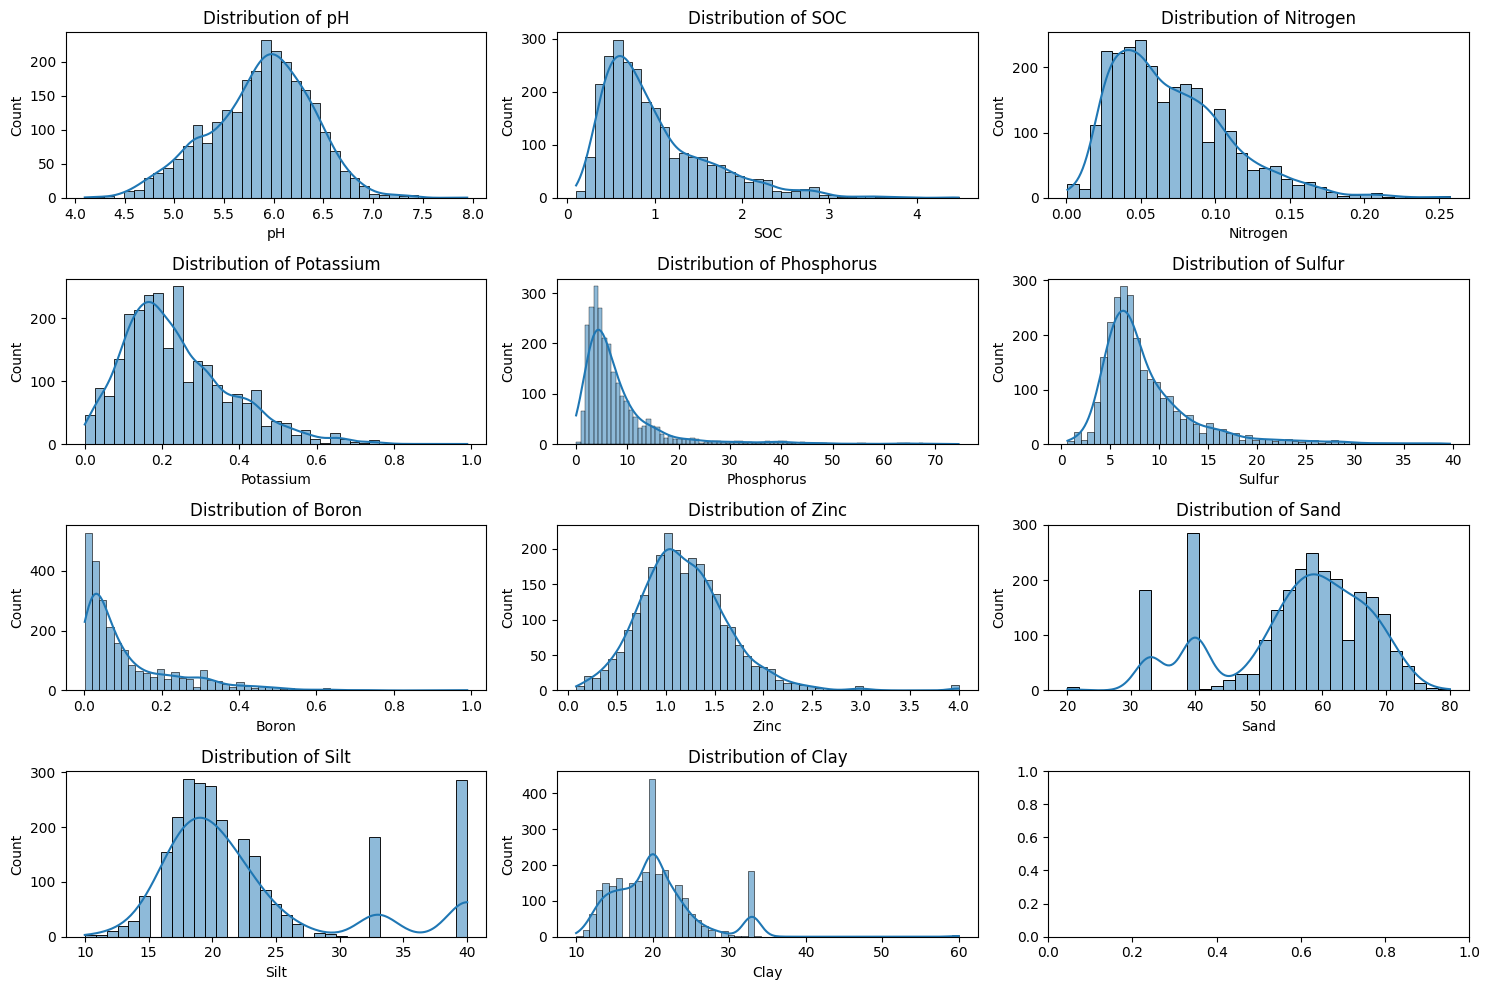

In [15]:
# Create subplots for each column
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))
axes = axes.flatten()

# Iterate through each column and plot its distribution
for i, column in enumerate(df1.columns):
    sns.histplot(data=df1, x=column, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

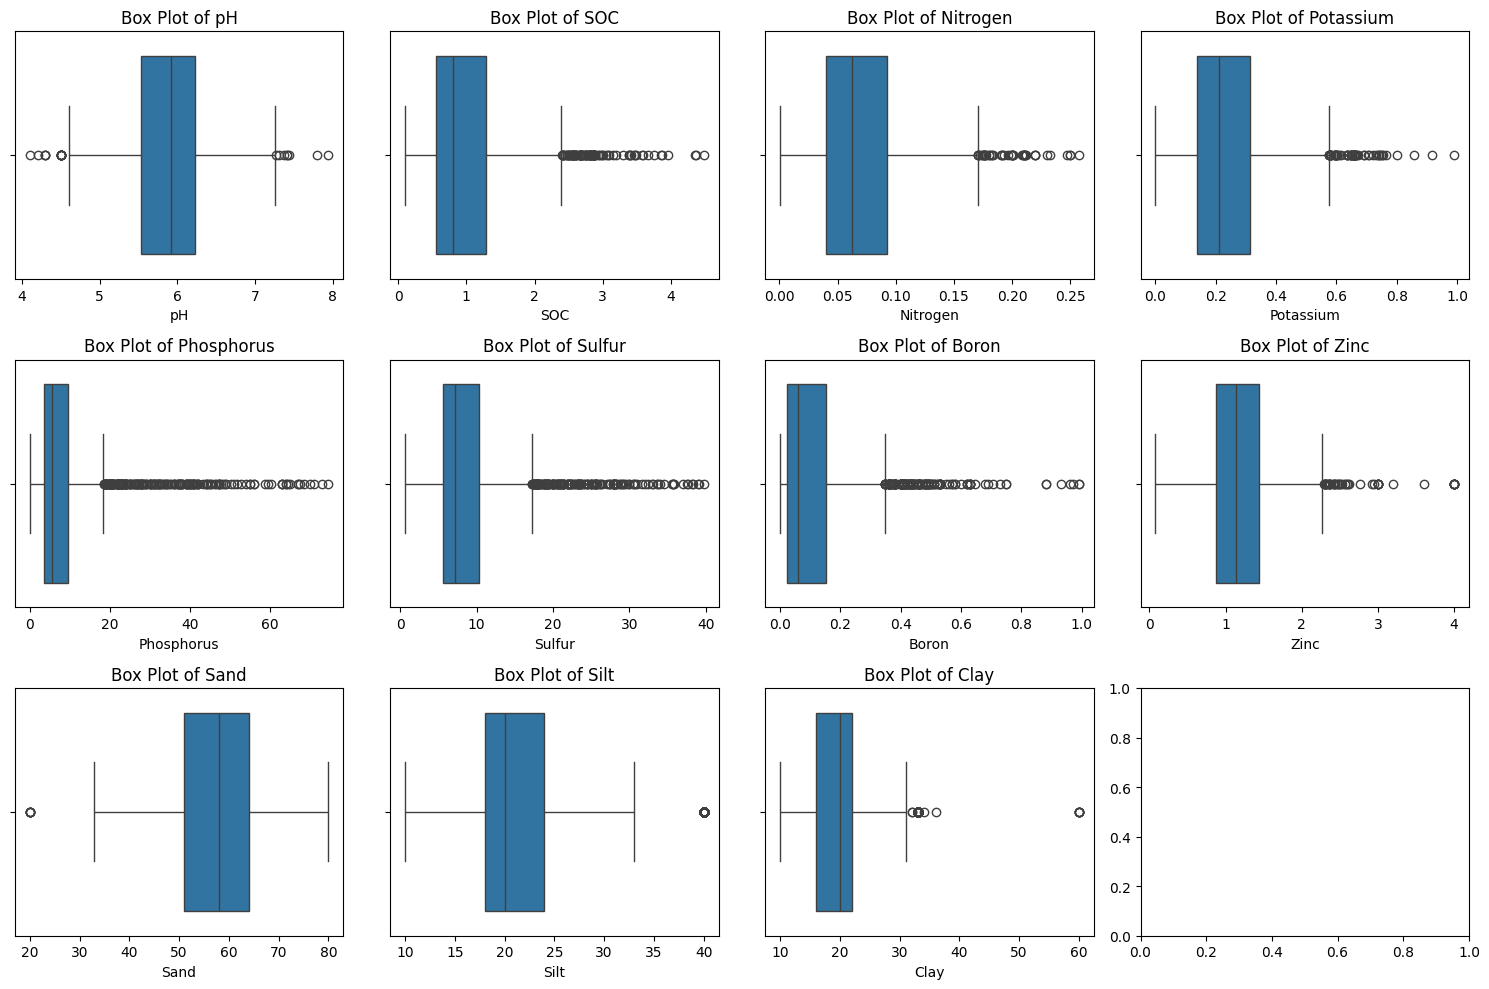

In [17]:
# Create subplots for each column
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
axes = axes.flatten()

# Plot box plots for each column
for i, column in enumerate(df1.columns):
    sns.boxplot(x=df[column], ax=axes[i])
    axes[i].set_title(f'Box Plot of {column}')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [18]:
df1.isnull().values.any()

False

In [19]:
df.duplicated().any()

False

In [20]:
# Separate features and targets
targets = ['SOC', 'Boron', 'Zinc']
X = df1.drop(columns=targets)
y = df1[targets]

### Preprocessing

In [23]:
# Numerical Columns
numerical_cols = X.columns.tolist()

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("yeo_johnson", PowerTransformer(method="yeo-johnson")),  # Yeo-Johnson Transformation
            ("scaler", StandardScaler())                        # Standard Scaling
        ]), numerical_cols)
    ]
)

# Fit the Preprocessor
pipeline = Pipeline(steps=[("preprocessor", preprocessor)])
pipeline.fit(X_train)

# Transform the Data
X_train_transformed = pipeline.transform(X_train)
X_test_transformed = pipeline.transform(X_test)

# Convert back to DataFrame for visualization
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=numerical_cols)



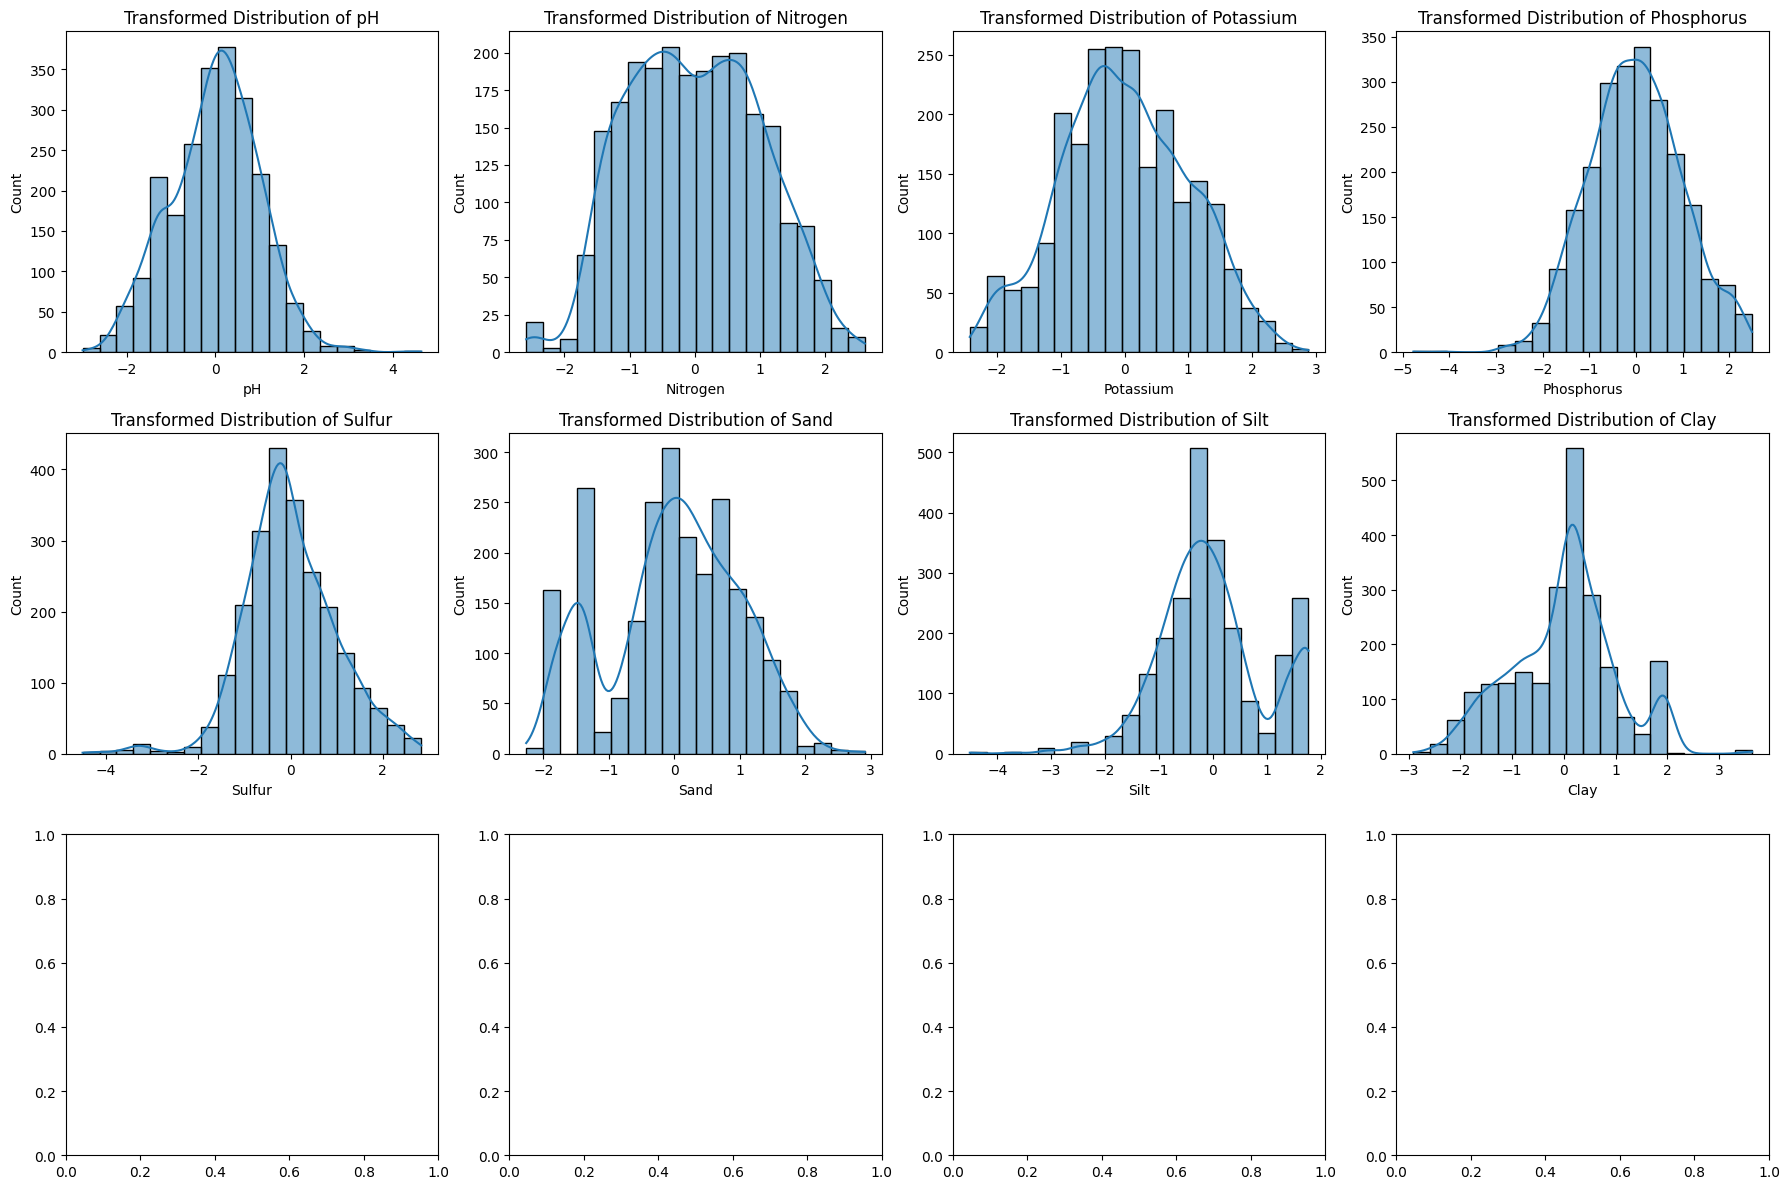

In [24]:
# Plot the Transformed Distributions
fig, axes = plt.subplots(2, 4, figsize=(18, 12))
axes = axes.flatten()
for i, col in enumerate(X_train_transformed_df.columns):
    sns.histplot(X_train_transformed_df[col], kde=True, ax=axes[i], bins=20)
    axes[i].set_title(f"Transformed Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

plt.tight_layout()
plt.show()

### Trying and evaluating various Models

In [31]:
# Models to evaluate
models = [
    ("Linear Regression", MultiOutputRegressor(LinearRegression())),
    ("XGBRegressor", MultiOutputRegressor(XGBRegressor())),
    ("TabNet", TabNetRegressor(verbose=0))  # PyTorch TabNet
]

# Evaluate models
results = []
for name, model in models:
    print(f"Training {name}...")

    if name == "TabNet":
        # TabNet-specific training
        # Reset index of y_train and y_test before fitting TabNet
        y_train_reset = y_train.reset_index(drop=True)
        y_test_reset = y_test.reset_index(drop=True)

        model.fit(
            X_train_transformed, y_train_reset.values,  # Pass NumPy array to TabNet
            eval_set=[(X_test_transformed, y_test_reset.values)],
            patience=10,
            max_epochs=100,
            batch_size=1024
        )
        predictions = model.predict(X_test_transformed)
    else:
        # Scikit-learn style models
        model.fit(X_train_transformed, y_train)
        predictions = model.predict(X_test_transformed)

    # Evaluate performance
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    rmse = np.sqrt(mse)
    results.append((name, mse, r2, rmse))
    print(f"{name}: MSE = {mse:.4f}, R2 = {r2:.4f}, RMSE = {rmse:.4f}")

# Display results
print("\nModel Performance Summary:")
for name, mse, r2, rmse in results:
    print(f"{name}: MSE = {mse:.4f}, R2 = {r2:.4f}, RMSE = {rmse:.4f}")

Training Linear Regression...
Linear Regression: MSE = 0.0925, R2 = 0.5044, RMSE = 0.3041
Training XGBRegressor...
XGBRegressor: MSE = 0.0747, R2 = 0.6016, RMSE = 0.2733
Training TabNet...

Early stopping occurred at epoch 31 with best_epoch = 21 and best_val_0_mse = 0.09064
TabNet: MSE = 0.0906, R2 = 0.4241, RMSE = 0.3011

Model Performance Summary:
Linear Regression: MSE = 0.0925, R2 = 0.5044, RMSE = 0.3041
XGBRegressor: MSE = 0.0747, R2 = 0.6016, RMSE = 0.2733
TabNet: MSE = 0.0906, R2 = 0.4241, RMSE = 0.3011


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [37]:
# Models to evaluate
models = [
    ("Linear Regression", MultiOutputRegressor(LinearRegression())),  # Ordinary Linear Regression
    ("Ridge Regression", MultiOutputRegressor(Ridge(alpha=10.0))),  # Regularized Linear Regression with tuned alpha
    ("XGBRegressor", MultiOutputRegressor(XGBRegressor(
        n_estimators=200, max_depth=6, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8))),
    ("TabNet", TabNetRegressor(verbose=0, n_d=16, n_a=16, gamma=1.5, n_steps=5, lambda_sparse=0.0001))
]

# Evaluate models
results = []
for name, model in models:
    print(f"Training {name}...")

    if name == "TabNet":
        # TabNet-specific training
        y_train_reset = y_train.reset_index(drop=True)
        y_test_reset = y_test.reset_index(drop=True)

        model.fit(
            X_train_transformed, y_train_reset.values,  # Pass NumPy array to TabNet
            eval_set=[(X_test_transformed, y_test_reset.values)],
            patience=20,
            max_epochs=200,
            batch_size=512,
            virtual_batch_size=128  # Smaller batch size for stability
        )
        predictions = model.predict(X_test_transformed)
    elif name in ["Linear Regression", "Ridge Regression"]:
        # Cross-validation for linear models
        from sklearn.model_selection import cross_val_predict

        # Get predictions for the test set using the fitted model
        model.fit(X_train_transformed, y_train)  # Fit the model on the training data
        predictions = model.predict(X_test_transformed) # Predict on the test data

    else:
        # Scikit-learn style models
        model.fit(X_train_transformed, y_train)
        predictions = model.predict(X_test_transformed)

    # Evaluate performance
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    rmse = np.sqrt(mse)
    results.append((name, mse, r2, rmse))
    print(f"{name}: MSE = {mse:.4f}, R2 = {r2:.4f}, RMSE = {rmse:.4f}")

# Display results
print("\nModel Performance Summary:")
for name, mse, r2, rmse in results:
    print(f"{name}: MSE = {mse:.4f}, R2 = {r2:.4f}, RMSE = {rmse:.4f}")

Training Linear Regression...
Linear Regression: MSE = 0.0925, R2 = 0.5044, RMSE = 0.3041
Training Ridge Regression...
Ridge Regression: MSE = 0.0925, R2 = 0.5042, RMSE = 0.3041
Training XGBRegressor...
XGBRegressor: MSE = 0.0654, R2 = 0.6419, RMSE = 0.2557
Training TabNet...

Early stopping occurred at epoch 58 with best_epoch = 38 and best_val_0_mse = 0.0733
TabNet: MSE = 0.0733, R2 = 0.5321, RMSE = 0.2707

Model Performance Summary:
Linear Regression: MSE = 0.0925, R2 = 0.5044, RMSE = 0.3041
Ridge Regression: MSE = 0.0925, R2 = 0.5042, RMSE = 0.3041
XGBRegressor: MSE = 0.0654, R2 = 0.6419, RMSE = 0.2557
TabNet: MSE = 0.0733, R2 = 0.5321, RMSE = 0.2707


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
